In [38]:
import gradio as gr
import pandas as pd
import numpy as np
import torch

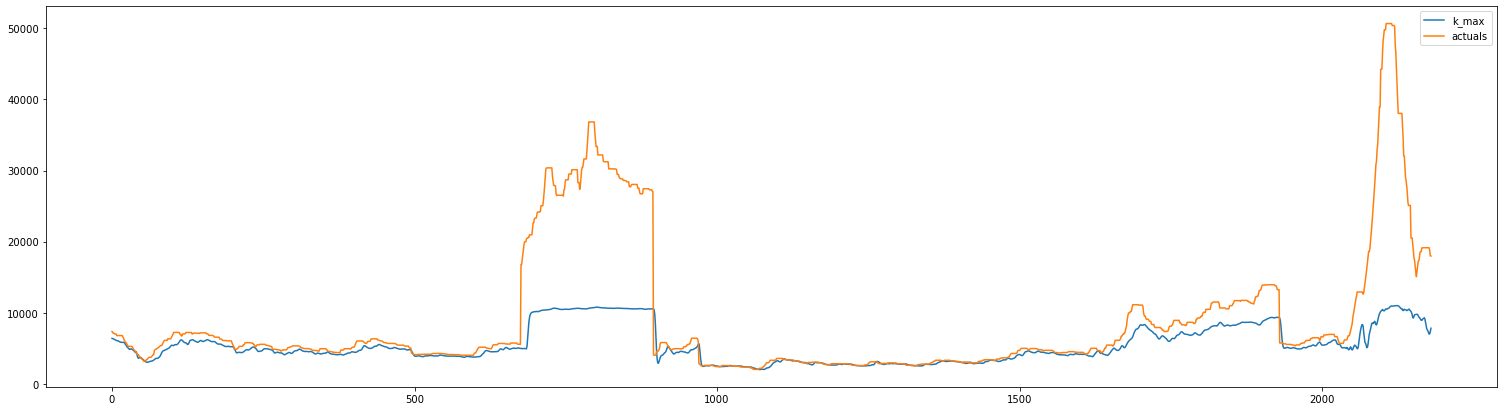

In [45]:
import os
from lightning_models import ForecastNextKDays_Boosted
from utils import create_dataset
import seaborn as sns
import matplotlib.pyplot as plt

def forecast(csvfile):

    df = pd.read_csv(csvfile, index_col=[0])

    model = ForecastNextKDays_Boosted.load_from_checkpoint("forecast-boosted\checkpoint.ckpt.ckpt")

    df = pd.read_csv(csvfile, index_col = [0])

    df_X = df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']] 
    df_y = df[['<CLOSE>']]

    df_X_scaled = model.scaler_X.transform(df_X)
    input, actuals = create_dataset(df_X_scaled, df_y, 21, 10)
    input = np.array(input).astype(np.float32)

    input = torch.tensor(input)

    model.eval()
    with torch.no_grad():

        output, _ = model(input) 

    preds = output.squeeze()
    preds = np.array(preds) 

    preds = pd.DataFrame(preds, columns = ['k_max'])
    preds[['k_max']] = model.scaler_y.inverse_transform(preds[['k_max']])
    preds[['actuals']] = actuals

    fig = plt.figure()
    sns.lineplot(data = preds, dashes = False, linewidth = 1)
    sns.color_palette("flare", as_cmap=True)
    fig.suptitle('Stock Prices', fontsize = 25)
    plt.xlabel('Day Count', fontsize = 16)

    return fig

In [46]:
interface = gr.Interface(forecast, 

                            inputs = gr.inputs.Textbox(lines=1, placeholder="Enter csv file path"),

                            outputs = [
                                        gr.Plot(label = "Stock Price", visible = True, show_label = True)
                                    ],

                            title = "Forecast",

                            css = """

                                body {background-color : lightblue}

                            """
                        ).launch()

c:\Anaconda\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Anaconda\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
c:\Anaconda\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7879/

To create a public link, set `share=True` in `launch()`.
